In [17]:
using DiffEqBayes
using Distributions
using DifferentialEquations
using Plots
using Turing

In [2]:
gr(fmt=:png)

Plots.GRBackend()

In [3]:
f = @ode_def_nohes LotkaVolterraTest begin
    dx = a*x - b*x*y
    dy = -c*y + d*x*y
end a=>1.5 b=>1.0 c=>3.0 d=>1.0

(::LotkaVolterraTest) (generic function with 20 methods)

In [4]:
u0 = [1.0,1.0]
tspan = (0.0,10.0)

(0.0, 10.0)

In [5]:
prob = ODEProblem(f,u0,tspan)
@time sol = solve(prob,Tsit5())

  5.915404 seconds (4.01 M allocations: 225.508 MiB, 4.39% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Array{Float64,1}:
  0.0      
  0.0776085
  0.232645 
  0.429118 
  0.679082 
  0.944406 
  1.26746  
  1.61929  
  1.98697  
  2.26409  
  2.51254  
  2.74682  
  3.038    
  ⋮        
  6.45576  
  6.7805   
  7.17104  
  7.58486  
  7.97806  
  8.48316  
  8.71924  
  8.9492   
  9.20018  
  9.43802  
  9.7118   
 10.0      
u: 34-element Array{Array{Float64,1},1}:
 [1.0, 1.0]         
 [1.04549, 0.857668]
 [1.17587, 0.63946] 
 [1.41968, 0.456996]
 [1.87672, 0.324733]
 [2.58825, 0.263362]
 [3.86071, 0.279446]
 [5.75081, 0.522006]
 [6.81498, 1.91778] 
 [4.39301, 4.19467] 
 [2.10088, 4.31696] 
 [1.24228, 3.10738] 
 [0.958273, 1.76616]
 ⋮                  
 [0.952206, 1.43835]
 [1.10046, 0.752663]
 [1.59911, 0.390319]
 [2.61424, 0.26417] 
 [4.24104, 0.305121]
 [6.79111, 1.1345]  
 [6.26541, 2.74165] 
 [3.78084, 4.43114] 
 [1.81645, 4.06409] 
 [1.14652, 2.79124] 
 [0.9558, 1.6236]   
 [1.03376, 0.90

In [6]:
t = collect(linspace(1,10,10))
sig = 0.49 
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(2)) for i in 1:length(t)]))

2×10 Array{Float64,2}:
  2.75365     7.87606  0.738678  …  1.35327  4.23179  3.19027  0.912644
 -0.00858571  1.48349  0.931987     1.01209  0.27797  5.50947  0.603971


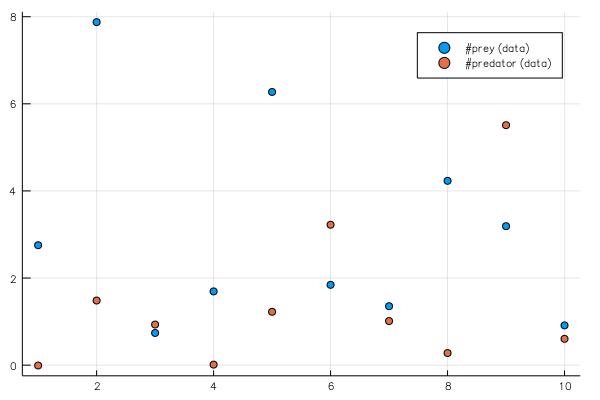

In [7]:
Plots.scatter(t, data[1,:], lab="#prey (data)")
Plots.scatter!(t, data[2,:], lab="#predator (data)")

In [8]:
priors = [Truncated(Normal(1.5,0.01),0.5,2.5),Truncated(Normal(1.0,0.01),0,2),Truncated(Normal(3.0,0.01),1,4),Truncated(Normal(1.0,0.01),0,2)]


4-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=1.5, σ=0.01), range=(0.5, 2.5))
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.01), range=(0.0, 2.0))
 Truncated(Distributions.Normal{Float64}(μ=3.0, σ=0.01), range=(1.0, 4.0))
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.01), range=(0.0, 2.0))

In [9]:
@time bayesian_result_stan = stan_inference(prob,t,data,priors;num_samples=100,num_warmup=500,vars =(StanODEData(),InverseGamma(3,2)))


File /home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.stan --o=/home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.stan
Output file=/home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
g++ -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.62.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe   -lpthread  -O3 -o /home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model src/cmdstan/main.cpp -i

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-6.33932 0.810731 … 3.00732 0.997152; -4.56203 0.985675 … 2.99738 1.00021; … ; -3.72224 0.981129 … 3.00108 1.0012; -3.02686 1.0 … 3.00621 1.00316]

[-1.85956 0.98488 … 3.00687 0.995063; -1.45041 0.971597 … 3.00199 0.996092; … ; -5.51168 0.8682 … 3.01776 0.992565; -8.25089 0.765261 … 3.02297 0.991916]

[-3.76811 0.774041 … 2.9985 1.00344; -3.21348 0.990277 … 3.01142 0.986875; … ; -6.38884 0.959569 … 3.00725 1.01512; -3.97582 1.0 … 2.99455 1.0103]

[-4.08175 0.951729 … 3.00705 0.99618; -5.62775 0.97805 … 3.00977 0.993085; … ; -4.44541 0.948514 … 3.01123 0.99211; -7.6708 0.853701 … 3.00121 0.981682])

In [10]:
Mamba.describe(bayesian_result_stan.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                  Mean         SD         Naive SE        MCSE         ESS    
         lp__ -4.06359748 1.7664384632 0.08832192316 0.18721518890  89.0255908
accept_stat__  0.91327376 0.0989396352 0.00494698176 0.00831745925 100.0000000
   stepsize__  0.60597300 0.0099117187 0.00049558593 0.00571537580   3.0075188
  treedepth__  2.77750000 0.4164460569 0.02082230284 0.01547847968 100.0000000
 n_leapfrog__  6.52000000 1.4193789457 0.07096894728 0.05887840578 100.0000000
  divergent__  0.00000000 0.0000000000 0.00000000000 0.00000000000         NaN
     energy__  7.11803850 2.6899260183 0.13449630092 0.34968775070  59.1724883
     sigma1.1  0.45508552 0.1156563551 0.00578281776 0.00185934644 100.0000000
     sigma1.2  0.60712623 0.1374717901 0.00687358951 0.00480522234 100.0000000
       theta1  1.50208455 0.0071380587 0.00035690293 0.00022202703 100.0000000
       theta2  0.

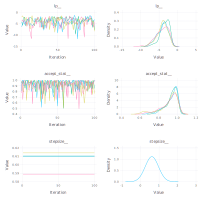

Press ENTER to draw next plot
STDIN> 


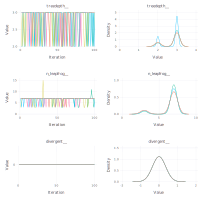

Press ENTER to draw next plot
STDIN> 


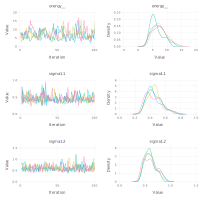

Press ENTER to draw next plot
STDIN> 


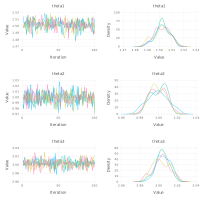

Press ENTER to draw next plot
STDIN> 


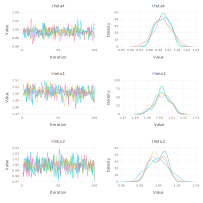

Press ENTER to draw next plot
STDIN> 


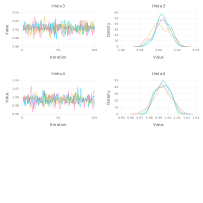

In [11]:
plot_chain(bayesian_result_stan)

In [13]:
@time bayesian_result_turing = turing_inference(prob,Tsit5(),t,data,priors;num_samples=500)

[HMC] Sampling... 17%  ETA: 0:00:05
  ϵ:         0.02
  α:         0.3763140587149052
[HMC] Sampling... 34%  ETA: 0:00:04
  ϵ:         0.02
  α:         1.0
[HMC] Sampling... 51%  ETA: 0:00:03
  ϵ:         0.02
  α:         0.12494917547967568
[HMC] Sampling... 69%  ETA: 0:00:02
  ϵ:         0.02
  α:         1.0
[HMC] Sampling... 82%  ETA: 0:00:01
  ϵ:         0.02
  α:         0.3422095086779313
[HMC] Sampling... 96%  ETA: 0:00:00
  ϵ:         0.02
  α:         0.8239032302771648
cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[HMC] Finished with
  Running time        = 6.324519912999991;
  Accept rate         = 0.708;
  #lf / sample        = 3.992;
  #evals / sample     = 3.996;
  pre-cond. diag mat  = [1.0, 1.0, 1.0, 1.0, 1.0].
  6.382425 seconds (5.27 M allocations: 1.490 GiB, 6.64% gc time)


[HMC] Sampling...100% Time: 0:00:06


Object of type "Turing.Chain"

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

[1.49645 5.196 … -9768.67 0.02; 0.543985 5.04172 … -5250.83 0.02; … ; 0.982812 0.578372 … -5.73127 0.02; 1.00316 0.514269 … -4.69783 0.02]

In [19]:
Mamba.describe(bayesian_result_turing)

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

Empirical Posterior Estimates:
             Mean                   SD                         Naive SE                 MCSE          ESS   
 theta4    0.995551470   0.040464172783845432646022  0.00180961281995950583161015   0.00121121171 500.000000
      σ    0.720215609   0.699531352956090479722207  0.03128399315204433844828102   0.19821601643  12.454804
 theta2    1.000109686   0.116441256673268211940808  0.00520741130613857402392730   0.00150080010 500.000000
 theta1    1.502380990   0.118580075017894914779504  0.00530306217034075266791859   0.00082200571 500.000000
 lf_num    3.992000000   0.178885438199983204388133  0.00800000000000000016653345   0.00800000000 500.000000
elapsed    0.012749847   0.004570901232203347305805  0.00020441691747288470910361   0.00060761051  56.591749
 theta3    2.998937107   0.027193633840723280964413  0.00121613627646191893583172   0.00466413940  33.993153
     lp -156.2721506

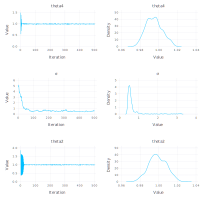

Press ENTER to draw next plot
STDIN> 


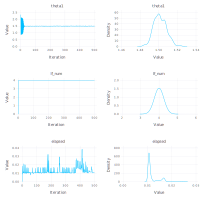

Press ENTER to draw next plot
STDIN> 


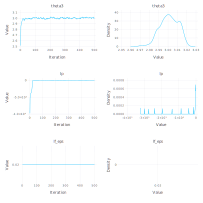

In [21]:
u = Mamba.plot(bayesian_result_turing)
Mamba.draw(u)